In [1]:
import gym
import numpy as np
import random
import imageio 
import math
from matplotlib import pyplot as plt

In [2]:
env = gym.make('CartPole-v1')

In [3]:
env.action_space

Discrete(2)

In [4]:
env.observation_space.shape

(4,)

In [5]:
from collections import deque
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)
    

In [6]:
from keras import layers, Sequential, optimizers
def create_model(input_shape, output_shape, learning_rate):
    model = Sequential()
    model.add(layers.Dense(32, input_shape=(input_shape,), activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(output_shape, activation='linear'))
    model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate = learning_rate))
    return model

In [7]:
rewards = []
episodes = []
average = []
def DeepQLearning(env, learning_rate, discount, epsilon, max_steps, episodes, input_shape, output_shape):
    
    model = create_model(
        input_shape=input_shape, 
        output_shape=output_shape, 
        learning_rate=learning_rate)
    
    memory = ReplayMemory(capacity=250000)
    batch_size = 32
    epislon_p = epsilon
    epsilon_min = 0.01
    epsilon_decay = 0.995
    gamma_p = discount




    for i in range(episodes):
        state, info = env.reset()
        state = np.reshape(state, (1, input_shape))
        done = False
        reward_tot = 0

        for j in range(max_steps):

            if np.random.rand() <= epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(model.predict(state, verbose=0)[0])


            new_state, reward, done, truncated, info = env.step(action)
            reward_tot += reward

            new_state = np.reshape(new_state, (1, input_shape))
            memory.push(state, action, reward, new_state, done)
            state = new_state

            # REPLAY
            if len(memory) >= batch_size:
                
                states, actions, rewards_b, next_states, dones = zip(*memory.sample(batch_size))

                states = np.squeeze(states)
                actions = np.array(actions)
                rewards_b = np.array(rewards_b)
                next_states = np.squeeze(next_states)
                dones = np.array(dones, dtype=np.bool_)

                targets = rewards_b + gamma_p * (np.amax(model.predict_on_batch(next_states), axis=1)) * (1 - dones)
                targets_full = model.predict_on_batch(states)

                targets_full[range(batch_size), actions] = targets
                model.fit(states, targets_full, epochs=1, verbose=0)
                
                if i>10 and epsilon > epsilon_min:
                    epsilon *= epsilon_decay

            if done:
                rewards.append(reward_tot)
                print("Episode :", i, "Step :", j, "Reward :", reward_tot, "Epsilon:", epsilon)
                break


In [8]:
env = gym.make('CartPole-v1')

DeepQLearning(env, 
          learning_rate=0.001, 
          discount=0.95, 
          epsilon=1.0, 
          max_steps=10000, 
          episodes=1000,
          input_shape=env.observation_space.shape[0],
          output_shape=env.action_space.n)

c:\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
c:\Python311\Lib\site-packages\gym\envs\classic_control\cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Episode : 0 Step : 31 Reward : 15.0 Epsilon: 1.0
Episode : 1 Step : 24 Reward : 25.0 Epsilon: 1.0
Episode : 2 Step : 10 Reward : 11.0 Epsilon: 1.0
Episode : 3 Step : 20 Reward : 21.0 Epsilon: 1.0
Episode : 4 Step : 13 Reward : 14.0 Epsilon: 1.0
Episode : 5 Step : 15 Reward : 16.0 Epsilon: 1.0
Episode : 6 Step : 18 Reward : 19.0 Epsilon: 1.0
Episode : 7 Step : 10 Reward : 11.0 Epsilon: 1.0
Episode : 8 Step : 9 Reward : 10.0 Epsilon: 1.0
Episode : 9 Step : 25 Reward : 26.0 Epsilon: 1.0
Episode : 10 Step : 16 Reward : 17.0 Epsilon: 1.0
Episode : 11 Step : 24 Reward : 25.0 Epsilon: 0.8822202429488013
Episode : 12 Step : 11 Reward : 12.0 Epsilon: 0.8307187014821328
Episode : 13 Step : 9 Reward : 10.0 Epsilon: 0.7901049725470279
Episode : 14 Step : 19 Reward : 20.0 Epsilon: 0.7147372386831305
Episode : 15 Step : 18 Reward : 19.0 Epsilon: 0.6498078359349755
Episode : 16 Step : 11 Reward : 12.0 Epsilon: 0.6118738784280476
Episode : 17 Step : 12 Reward : 13.0 Epsilon: 0.5732736268885887
Episode

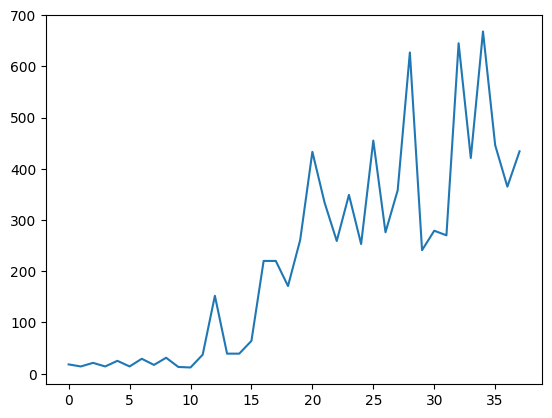

In [39]:
plt.plot(rewards)

In [8]:
env = gym.make('CartPole-v1', render_mode = 'rgb_array')
state,info = env.reset()

input_shape = env.observation_space.shape
output_shape = env.action_space.n

model = create_model(
        input_shape=input_shape, 
        output_shape=output_shape, 
        learning_rate=0.05
)
model.load_weights('model.h5')


images = []

while 1>0:

    action = np.argmax(model.predict(state[np.newaxis, :], verbose=0))
    new_state, reward, done, trunc, info = env.step(action)
    frame = env.render()  # Save the frame
    images.append(frame)


    stat = new_state
    if done == True:
        break

env.close()
imageio.mimsave('img/CartPole12.gif', images, fps=59)